In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/cansim-0800020-eng-6674700030567901031.csv', skiprows=6, skipfooter=9)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [3]:
from pandas.tseries.offsets import MonthEnd

In [4]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments') 

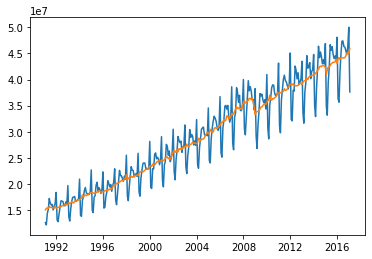

In [5]:
plt.plot(df)

In [6]:
split_date = pd.Timestamp('01-01-2011')

In [7]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

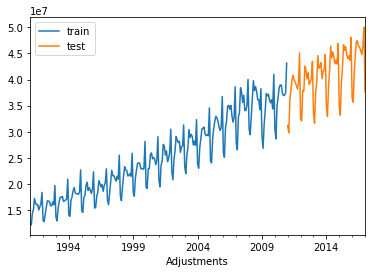

In [8]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train','test'])

In [10]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [11]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [12]:
train_sc.shape

(240, 1)

In [13]:
train_sc_df = pd.DataFrame(train_sc, columns = ['Scaled'], index = train.index)
test_sc_df = pd.DataFrame(test_sc, columns = ['Scaled'], index = test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [14]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [15]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [16]:
X_train = train_sc_df.dropna().drop('Scaled', axis = 1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis = 1)
y_test = test_sc_df.dropna()[['Scaled']]

In [17]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [18]:
X_train.shape

(228, 12)

In [19]:
X_train = X_train.values
X_test = X_test.values

y_train = y_train.values
y_test = y_test.values

In [20]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [31]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor = 'loss', patience = 1, verbose = 1)

In [33]:
K.clear_session()

model = Sequential()
model.add(LSTM(6, input_shape = (12, 1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [34]:
model.fit(X_train_t, y_train, epochs = 300, batch_size = 1, verbose = 1, callbacks = [early_stop])

Epoch 1/300
228/228 [==============================] - 2s 3ms/step - loss: 0.1417
Epoch 2/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0118
Epoch 3/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0080
Epoch 4/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0078
Epoch 5/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 6/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0073
Epoch 00006: early stopping


In [35]:
y_pred = model.predict(X_test_t)

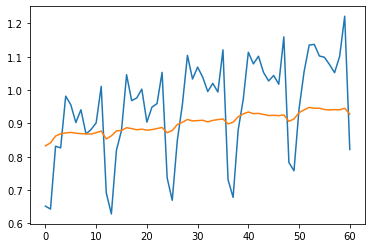

In [36]:
plt.plot(y_test)
plt.plot(y_pred)